In [1]:
import constants
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import emissions_new

#from helpers_new import rk4
#from helpers_new import ODEs_nineboxes


## Helper Functions

In [2]:
def ODEs_nineboxes(t,M,sauce): # ODE function, fxy in rk4 function
    # t: time 
    # M: 1x9 array, updated mass of each box 
  n_boxes = len(M) # number of boxes, 9
  ODEs = np.zeros(n_boxes)
  
  for r in range(n_boxes): # create a 1x9 array containing an ODE for each box
      ODEs[r] = -np.sum(M[r]*rate_constants_nineboxes[r,:]) + (rate_constants_nineboxes[:,r] @ M) # M flux out + M flux in
      ODEs[r] += sauce(t)[r] # source term
  return ODEs

def calc_rate_const(Mi0,Fi0): # rate constant between each box
    n_boxes = len(Mi0)  # number of boxes, 9

    rate_constant = np.zeros((n_boxes, n_boxes)) # 9x9 array
    for c in range(n_boxes):
        for r in range(n_boxes):
            if (Mi0[r] != 0): # prevent div by 0
              rate_constant[r,c] = Fi0[r,c]/Mi0[r] # put rate constant into the array calculated as flux/mass
                                                   # for example rate constant[0,2] is the rate constant from box 1 to box 3
    return rate_constant

# run rate const. funct. to initialize the rate constant array
rate_constants_nineboxes = calc_rate_const(Mi0=constants.Mi0_nineboxes,Fi0=constants.Fi0_nineboxes)

# runge kutta solver
def rk4(fxy, x0, xf, y0, N, sauce):

    # The inputs to the function are:
    #         fxy = the name of the function containing f(x,y) (e.g. oneode, twoode)
    #         xo,xf = initial and final values of the independent variable (integers or floats)
    #         yo = initial value of dependent variable at xo (numpy array)
    #         N = number of intervals to use between xo and xf (integer)

    # The outputs to the function are:
    #         X = numpy array containing values of the independent variable
    #         Y = the estimated dependent variable at each value of the independent variable
    #         --> this variable is a 1D numpy array if only one equation is solved
    #         --> it is an M-D numpy array [y1(x) y2(x) ... ] for multiple (M) equations

    #compute step size and size of output variables
    if N < 2:
        N = 2 #set minimum number for N
    h = (xf - x0) / N
    #print(f'STEP SIZE: {h}')
    X = np.zeros((N+1, 1))
    M = np.max(np.shape(y0))
    Y = np.zeros((N+1, M)) *1j #make complex by multiplying by 1j; this way can add complex values to this during integration

    #set initial conditions
    x = x0
    X[0] = x
    y = [complex(val) for val in y0]  #make complex
    Y[0,:] = y

    #begin computational loop
    for ii in range(N):

        k1 = np.array([h * val for val in fxy(x,y,sauce)]) #evaluate function fxy; depending on equation, k1-4 can be complex; this is why we make Y and y complex as well
        k2 = np.array([h * val for val in fxy(x+h/2, y+k1/2,sauce)])
        k3 = np.array([h * val for val in fxy(x+h/2, y+k2/2,sauce)])
        k4 = np.array([h * val for val in fxy(x+h, y+k3,sauce)])

        y += (k1 + 2*k2 + 2*k3 + k4) / 6.
        x += h
        X[ii+1] = x
        Y[ii+1,:] = y

    return X, Y


    #Constants, Integration time, time steps and initial conditions: This information could be contained in a separate input file that you call


## Load data

In [3]:
#data from Byrne et. al. for use in Q5
can_fires_2023 = np.genfromtxt('./plot-data (1).csv', delimiter=',') # load data
can_fire_t = can_fires_2023[:,0] 
can_fire_t[0] = 0 #replace NaN
can_fire_rates = np.zeros(len(can_fires_2023))
for i in range(len(can_fires_2023)-2): #use cumulitive Carbon data to solve for rate
    dx = can_fires_2023[i+2,0]-can_fires_2023[i+1,0]
    dy = can_fires_2023[i+2,1]-can_fires_2023[i+1,1]
    can_fire_rates[i+1] = dy/dx
   

## Set up forcing functions

In [4]:
#Forcing Functions
def constant(value = 0): # function to force a constant ammount of CO2 into atmosphere, default to zero, use for any box w/o source   
    return value
    
def dump(yr,tot,duration): # function to force some ammount (tot) of CO2 into atmosphere over a set ammount of time (duration)
    t_yr = np.array([0, 9.999,10, 10+duration, 10.001+duration, 10000])
    
    # CO2 forcing stops at 2100: note that need some zeros close in time to approximate stepwise shutoff with linear interp
    
    e_GtC_yr = np.array([0, 0, tot/duration, tot/duration, 0, 0])
    
    e = np.interp(yr, t_yr, e_GtC_yr)
    
    return e
    

def periodic_forcing(yr,amplitude,mean,period): 
    #perriodic forcing function, -cos function centered at mean. 
    #eg. periodic_forcing(yr,amplitude=100,mean=100,period=1) 
    #gives annual cycle where 200 Gt/y is released mid summer and 0 Gt is released in mid winter
    e = -amplitude * np.cos(2*np.pi*yr/period)+mean
    return e
    
def decaying_periodic_forcing(yr,amplitude,mean,period,efold):
    #same as periodic_forcing() with addition of a decay term regulated by efolding length
    e = (-amplitude  * np.cos(2*np.pi*yr/period)+mean)* np.exp(-(yr-xinitial)/efold)
    return e

def can_fire_funct(yr):
    # function returning CO2 release rate data from Byrne et. al. 2024)
    # will return 2023 rate for every year
    t_yr = np.array([0,0.37        , 0.37196471, 0.39072848, 0.41390728, 0.43377483,
           0.45033113, 0.48785875, 0.50993377, 0.52207512, 0.54966887,
           0.58830029, 0.60154532, 0.63245033, 0.64790294, 0.66004418,
           0.66887417, 0.67549669, 0.69977928, 0.7218543 , 0.73068439,
           0.75165563, 0.76269319, 0.77483444, 0.78807947, 0.79580577,
           0.81567332])
    e_GtC_yr = np.array([0,    0.        ,   433.79199958,  2106.97674419,   936.43053631,
        2809.30446891,  3284.40292235,   579.41788128,  3830.84847429,
        1179.90921438,  2046.77429863,   438.95080921,  1354.48800238,
         376.24535509,  1436.57903839,   658.43475366,  2984.87836261,
         478.85914806,  2581.04964625,  3292.12403651,   110.89471514,
        1580.22773567,  1532.35170497,   526.74418605, 10083.34589263,
         175.58139535,     0.        ])
    e = np.interp(yr-int(yr), t_yr, e_GtC_yr)
    return e


def can_fire_funct_decay(yr,efold):
    #same as can_fire_funct(yr) with addition of a decay term regulated by efolding length
    t_yr = np.array([0,0.37        , 0.37196471, 0.39072848, 0.41390728, 0.43377483,
           0.45033113, 0.48785875, 0.50993377, 0.52207512, 0.54966887,
           0.58830029, 0.60154532, 0.63245033, 0.64790294, 0.66004418,
           0.66887417, 0.67549669, 0.69977928, 0.7218543 , 0.73068439,
           0.75165563, 0.76269319, 0.77483444, 0.78807947, 0.79580577,
           0.81567332])
    e_GtC_yr = np.array([0,    0.        ,   433.79199958,  2106.97674419,   936.43053631,
        2809.30446891,  3284.40292235,   579.41788128,  3830.84847429,
        1179.90921438,  2046.77429863,   438.95080921,  1354.48800238,
         376.24535509,  1436.57903839,   658.43475366,  2984.87836261,
         478.85914806,  2581.04964625,  3292.12403651,   110.89471514,
        1580.22773567,  1532.35170497,   526.74418605, 10083.34589263,
         175.58139535,     0.        ])
    e = np.interp(yr-int(yr), t_yr, e_GtC_yr)
    return e #*  np.exp(-(yr-xinitial)/efold)
    
#def deforest_sink(yr,efold,amp): #decaying sink to model deforestation 
#    e = -amp * np.exp(-(yr-xinitial)/efold)
#    return e

## Question 3, Periodic Forcing

In [5]:
# set up source term functions for q3 experiment with periodic forcing 

def fynktorg_periodic_decay(t): 
    #gives annual cycle where 800 Gt/y is released mid summer and 0 Gt is 
    #released in mid winter initially and decays over time with efoldingtime of 6 years
    bn_source = [decaying_periodic_forcing(yr=t,amplitude=400,mean=400,period=1,efold=6),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant()]
    return bn_source

def fynktorg_periodic(t):
     #gives annual cycle where 800 Gt/y is released mid summer and 0 Gt is released in mid winter
    bn_source = [periodic_forcing(yr=t,amplitude=400,mean=400,period=1),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant()]
    return bn_source

def fynktorg_periodic_long(t):
    # same amplitude as above with 5 year period
    bn_source = [periodic_forcing(yr=t,amplitude=400,mean=400,period=5),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant()]
    return bn_source

In [6]:
#run RK4 solver for each source term function

xinitial = 2024 # starting year
xfinal =   2034 #f inal year

n= (12*2) * (xfinal-xinitial) # number of time steps total duration / nyquist freq 

rungekutta_periodic = rk4(fxy=ODEs_nineboxes, x0=xinitial, xf=xfinal, y0=constants.Mi0_nineboxes, N=n, sauce = fynktorg_periodic)
rungekutta_periodic_decay = rk4(fxy=ODEs_nineboxes, x0=xinitial, xf=xfinal, y0=constants.Mi0_nineboxes, N=n, sauce = fynktorg_periodic_decay)
rungekutta_periodic_long = rk4(fxy=ODEs_nineboxes, x0=xinitial, xf=xfinal, y0=constants.Mi0_nineboxes, N=n, sauce = fynktorg_periodic_long)

/var/folders/y6/s7pmyb9j2jv_r2sv3b1v67r00000gn/T/ipykernel_37342/3264592299.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  ODEs[r] = -np.sum(M[r]*rate_constants_nineboxes[r,:]) + (rate_constants_nineboxes[:,r] @ M) # M flux out + M flux in


/Users/ejb/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/ejb/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


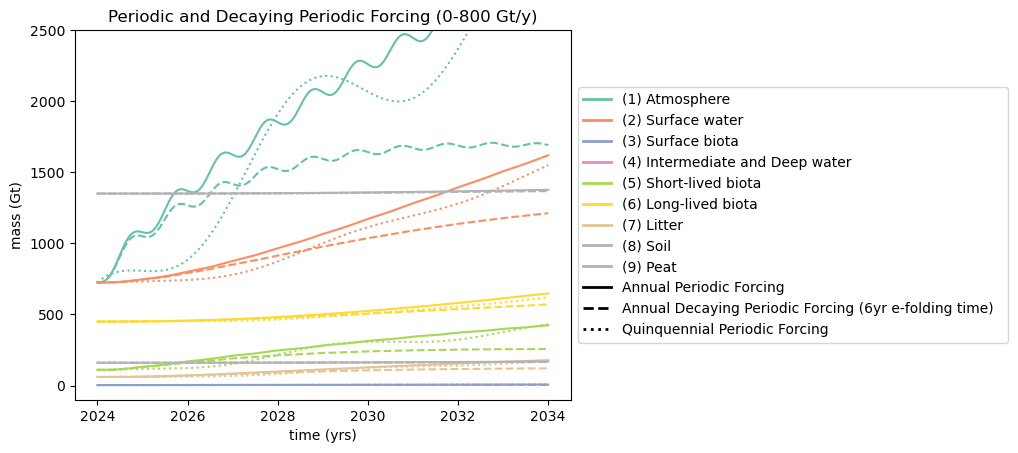

In [7]:
# plot periodic forcing

cmap = plt.get_cmap('Set2') #color map
# Generate colors from the colormap (9 colors for the 9 categories)
colors = [cmap(i) for i in np.linspace(0, 1, 9)]

ninebox_legend_arr = ['(1) Atmosphere', '(2) Surface water ', '(3) Surface biota ', #labels
                      '(4) Intermediate and Deep water ', '(5) Short-lived biota ', '(6) Long-lived biota ',
                      '(7) Litter ', '(8) Soil ', '(9) Peat']



# Plot each line with different line styles and colors
for i in range(len(rungekutta_periodic[1][0])):    
    plt.plot(rungekutta_periodic[0], rungekutta_periodic[1][:,i], linestyle='-', color=colors[i]) #1 year period, no decay
    plt.plot(rungekutta_periodic_decay[0], rungekutta_periodic_decay[1][:,i], linestyle='--', color=colors[i]) #1 year period, w/ decay
    plt.plot(rungekutta_periodic_long[0], rungekutta_periodic_long[1][:,i], linestyle=':', color=colors[i]) #5 year period, no decay

plt.title('Periodic and Decaying Periodic Forcing (0-800 Gt/y)')
plt.xlabel('time (yrs)')
plt.ylabel('mass (Gt)')



# Create custom legend entries for colors (for each category)
color_lines = [Line2D([0], [0], color=colors[i], lw=2, linestyle='-', label=ninebox_legend_arr[i]) for i in range(9)]

style_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Annual Periodic Forcing'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Annual Decaying Periodic Forcing (6yr e-folding time)  '),
    Line2D([0], [0], color='black', lw=2, linestyle=':', label='Quinquennial Periodic Forcing ')
]

# Combine the color and line style into one legend
plt.legend(handles=color_lines + style_lines, loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylim(-100, 2500)
plt.savefig('fig3_periodic_forcing.png', dpi=300, bbox_inches='tight')

## Question 4, constant total additions at variable rate

In [8]:
# set up source term functions for q4 experiment where a consistent ammount of co2 is added at variable rates

def fynktorg1(t): #750 Gt/y for 1 year
    bn_source = [dump(t,750,1), #only sourced into atmosphere
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant()]
    return bn_source

def fynktorg2(t): #75 Gt/y for 10 years
    bn_source = [dump(t,750,10), 
                 constant(), 
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant()]
    return bn_source
    
def fynktorg3(t): #7.5 Gt/y for 100 years
    bn_source = [dump(t,750,100),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant()]
    return bn_source

In [9]:
#run RK4 solver for each source term function

xinitial = 0 # starting year
xfinal =   100 # final year

n= (12*2) * (xfinal-xinitial) # number of time steps total duration / nyquist freq 


rungekutta_nine1 = rk4(fxy=ODEs_nineboxes, x0=xinitial, xf=xfinal, y0=constants.Mi0_nineboxes, N=n, sauce = fynktorg1) #750 Gt/y
rungekutta_nine2 = rk4(fxy=ODEs_nineboxes, x0=xinitial, xf=xfinal, y0=constants.Mi0_nineboxes, N=n, sauce = fynktorg2) #75 Gt/y
rungekutta_nine3 = rk4(fxy=ODEs_nineboxes, x0=xinitial, xf=xfinal, y0=constants.Mi0_nineboxes, N=n, sauce = fynktorg3) #7.5 Gt/y

/var/folders/y6/s7pmyb9j2jv_r2sv3b1v67r00000gn/T/ipykernel_37342/3264592299.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  ODEs[r] = -np.sum(M[r]*rate_constants_nineboxes[r,:]) + (rate_constants_nineboxes[:,r] @ M) # M flux out + M flux in


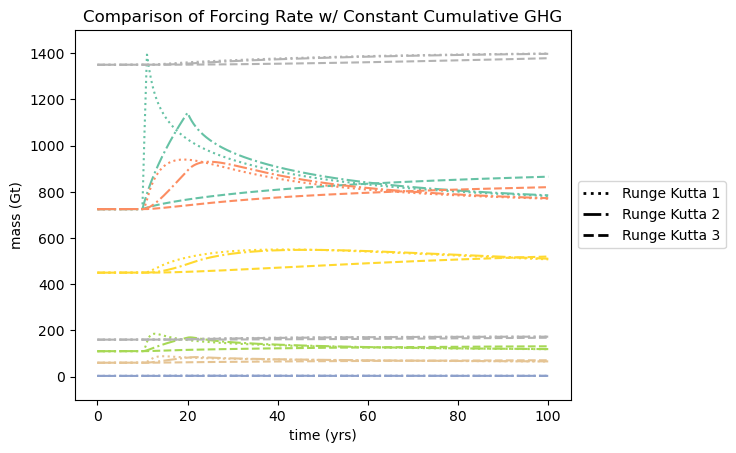

In [10]:
cmap = plt.get_cmap('Set2')
ninebox_legend_arr = ['(1) Atmosphere', '(2) Surface water ', '(3) Surface biota ',
                     '(4) Intermediate and Deep water ', '(5) Short-lived biota ', '(6) Long-lived biota ',
                     '(7) Litter ', '(8) Soil ', '(9) Peat ']

# Generate colors from the colormap
colors = [cmap(i) for i in np.linspace(0, 1, 9)]  # Generate 9 colors for the 2 lines
for i in range(len(rungekutta_nine1[1][0])):    
    plt.plot(rungekutta_nine1[0],rungekutta_nine1[1][:,i],linestyle = ':',color = colors[i],label = ninebox_legend_arr[i])
    
    plt.plot(rungekutta_nine2[0],rungekutta_nine2[1][:,i],linestyle = '-.',color = colors[i])

    plt.plot(rungekutta_nine3[0],rungekutta_nine3[1][:,i],linestyle = '--',color = colors[i])
plt.title('Comparison of Forcing Rate w/ Constant Cumulative GHG')
plt.xlabel('time (yrs)'), plt.ylabel('mass (Gt)')


custom_lines = [Line2D([0], [0], color='black', linestyle=':', lw=2, label='Runge Kutta 1'),
                Line2D([0], [0], color='black', linestyle='-.', lw=2, label='Runge Kutta 2'),
                Line2D([0], [0], color='black', linestyle='--', lw=2, label='Runge Kutta 3')]


plt.legend(handles=custom_lines, loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-100,1500)
plt.show()


## Question 5: 2023 fire scenario

In [11]:
def fynktorg_fire(t):
    bn_source = [can_fire_funct(yr=t),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant(),
                 constant()]
    return bn_source

In [12]:
#run RK4 solver for each source term function
xinitial = 2023
xfinal =   2050

n= (12*2) * (xfinal-xinitial) # number of time steps total duration / nyquist freq 

rungekutta_ninefire = rk4(fxy=ODEs_nineboxes, x0=xinitial, xf=xfinal, y0=constants.Mi0_nineboxes, N=n, sauce = fynktorg_fire)

/var/folders/y6/s7pmyb9j2jv_r2sv3b1v67r00000gn/T/ipykernel_37342/3264592299.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  ODEs[r] = -np.sum(M[r]*rate_constants_nineboxes[r,:]) + (rate_constants_nineboxes[:,r] @ M) # M flux out + M flux in


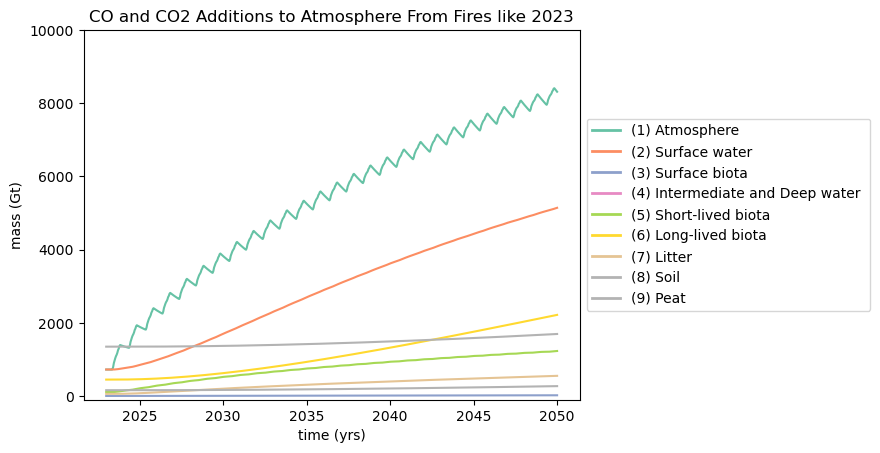

In [13]:


cmap = plt.get_cmap('Set2')
ninebox_legend_arr = ['(1) Atmosphere', '(2) Surface water ', '(3) Surface biota ',
                      '(4) Intermediate and Deep water ', '(5) Short-lived biota ', '(6) Long-lived biota ',
                      '(7) Litter ', '(8) Soil ', '(9) Peat']

# Generate colors from the colormap (9 colors for the 9 categories)
colors = [cmap(i) for i in np.linspace(0, 1, 9)]

# Plot each line with different line styles and colors
for i in range(len(rungekutta_ninefire[1][0])):    
    plt.plot(rungekutta_ninefire[0], rungekutta_ninefire[1][:,i], linestyle='-', color=colors[i])

plt.title('CO and CO2 Additions to Atmosphere From Fires like 2023')
plt.xlabel('time (yrs)')
plt.ylabel('mass (Gt)')

# Create custom legend entries for colors (for each category)
color_lines = [Line2D([0], [0], color=colors[i], lw=2, linestyle='-', label=ninebox_legend_arr[i]) for i in range(9)]

# legend
plt.legend(handles=color_lines , loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylim(-100, 10000)
plt.savefig('fig5_2023_fires.png', dpi=300, bbox_inches='tight')
